<h1 align="center">Performance Robustness Evaluation for Statistical Classifiers (PRESC) </h1> 

## Exploration of effect on the metric of the number of k-folds in cross-validation

K-fold cross-validation is a method that allows to evaluate a model with different subsets of the original data so that, in the end, all data has been used for testing once (and for training several times).

The general procedure is as follows:

1.    Shuffle the dataset randomly.
2.    Split the dataset into k groups  

    For each unique group:    


3.    Take the group as a holdout or test data set
4.    Take the remaining groups as a training data set
5.    Fit a model on the training set and evaluate it on the test set
6.    Retain the evaluation score and discard the model
7.    Summarize the skill of the model using the sample of model evaluation scores

Example of cross validation scheme for 5 k-folds vs simple holdout of a 18% of the sample for validation ([by Merve Bayram Durna](https://medium.com/@mervebdurna/what-is-cross-validation-how-does-it-work-1494774519e4)):
<img src="img/k-fold_cv_scheme_by_Merve_Bayram_Durna.png" alt="Cross validation scheme by Merve Bayram Durna">

**Choosing the number of k-folds with which to carry out the cross-validation is not an obvious decision.** A larger number of k-folds will mean that the training sample for each k-fold is closer to the full dataset and that they are more similar among them because they will have more overlap, as well as a larger number of different scores to average, but the validation subsets will be smaller and yield a higher variance. Also, a higher number of k-folds will be more computationally demanding.

For instance, if we divide the data in two k-folds this will correspond to a train/test split of 50/50 for each k-fold where we will only obtain two different performace values (one per fold) to average. Choosing ten k-folds will correspond to a train/test split of 90/10 obtaining ten performance values to average, and setting the number of k-folds identical to the number of data points corresponds to a leave-one-out cross validation scheme where all the data points but one are used for training, and the model is validated for one point on each iteration. 

Smaller training samples (i.e., a smaller number of k-folds) make it easier that the training subset is not as representative and that the classifier has biases, hence, if the whole cross validation process is repeated, there will be more variation among those runs. One way to counteract this effect for small numbers of k-folds is to run the cross validation several times and average all those values.

Check [this link](https://stats.stackexchange.com/questions/27730/choice-of-k-in-k-fold-cross-validation) for a discussion on this topic.


The function **"explore_cross_validation_kfolds"** demonstrated in this notebook allows to explore the k-fold space to determine the optimal number of k-folds.

Parameters:

* pipeline: Can be a scaler and a classifier or only the classifier.
* metrics: List of the metrics. Although so far only "accuracy" is possible, although the fit and scoring times are also computed.
* kfolds_list: List of the number of k-folds for which to compute the cross-validation scores.
* repetitions: Number of times to repeat the cross-validation for      each k-fold number (if "minimum_kfolds" is set to False) or minimum number of k-folds that must be computed (if "minimum_kfolds" is set to True). By default it carries out the cross-validation ten times for each requested k-fold value. If "repetitions" is set to one, the resulting standard deviation values correspond to those computed for each individual cross-validation.
* minimum_kfolds: If "minimum_kfolds" is set to True, "repetitions" becomes the minimum number of k-folds. The number of needed cross-validation runs for each k-fold value are computed so that the total number of k-folds after all computations reach that      minimum. For example, the cross validation for five k-folds yields five performance values so, if the minimum number of repetitions is set to ten, the cross validation will be repeated twice.

In [1]:
import sys
sys.path.append("../")

import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from presc.training_stability.cross_validation import explore_cross_validation_kfolds
from presc.training_stability.training_stability_common import show_averages_and_variations

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


def show_averages_and_variations(
    x,
    averages,
    standard_deviations,
    x_name="test subset fraction",
    metric_name="accuracy",
):
    """
    Displays averages and their standard deviations.

    This function allows in general to visualize data corresponding to many
    repetitions, by showing the averages as a function of a variable and their
    corresponding standard deviations.

    Parameters
    ----------
    x : list or numpy array
        Values of the x-axis variable.
    averages : list or numpy array
        Values of the metric averages (y axis).
    standard_deviations : list or numpy array
        Standard deviations from the metric average values (y axis).
    x_name : str
        Variable name that will be used to label the x axis of the graph.
    metric_name : str
        Name of the metric or score that has been repeatedly computed,
        and that will be used in the labeling of the y axis.
    """
    averages = np.asarray(averages)
    standard_deviations = np.asarray(standard_deviations)

    figure, axs = plt.subplots(1, 2, figsize=(15, 6))

    mpl.rc("font", size=12)
    mpl.rc("axes", titlesize=12)

    axs[0].plot(x, averages, color="slateblue", linewidth=2.0)
    axs[0].fill_between(
        x,
        averages - standard_deviations,
        averages + standard_deviations,
        color="lavender",
    )
    axs[0].set_xlabel(x_name.capitalize())
    axs[0].set_ylabel("Average " + metric_name)

    axs[1].scatter(x, standard_deviations)
    axs[1].set_xlabel(x_name.capitalize())
    axs[1].set_ylabel(metric_name.capitalize() + " standard deviation")

    plt.show(block=False)

    print(
        "\nIndex of point where " + metric_name + " has the smallest standard "
        f"deviation: {standard_deviations.argmin()}"
    )
    print(
        "\n" + x_name + " where " + metric_name + " has smallest standard "
        f"deviation: {x[standard_deviations.argmin()]:.4f}"
        "\nAverage " + metric_name + " at " + x_name + " with the smallest standard "
        f"deviation: {averages[standard_deviations.argmin()]:.4f}"
    )

## Load dataset

In [2]:
dataset_names = ("generated", "vehicles", "eeg", "winequality", "defaults")
dataset_files = ["../datasets/" + dataset_names[x] + ".csv" for x in range(len(dataset_names))]

In [3]:
dataset = pd.read_csv(dataset_files[4])[:300]
# Readjust "pay" values to range from -1 to 9
dataset.iloc[:,6:12] = dataset.iloc[:,6:12].add(1)

## Define pipeline and exploration metric

In [4]:
scaler = StandardScaler()
classifier = SVC(kernel='linear', C=1, random_state=0)
pipeline = Pipeline([('scaler', scaler), ('classifier', classifier)])

metrics = ["accuracy"]

## Exploration of the number of k-folds space

### Low k-fold numbers and no repetitions
For low k-fold numbers there are less values to average and the signal is more noisy, to solve that, we can set the repetitions option to > 1 to repeat the cross-validation several times for each k-fold and average those values. Here we show the case were no repetitions are carried out.

In [5]:
kfolds_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
kfolds_list, scores_summary = explore_cross_validation_kfolds(dataset, pipeline, metrics=metrics, 
                                                              kfolds_list=kfolds_list, repetitions=1, 
                                                              minimum_kfolds=False)

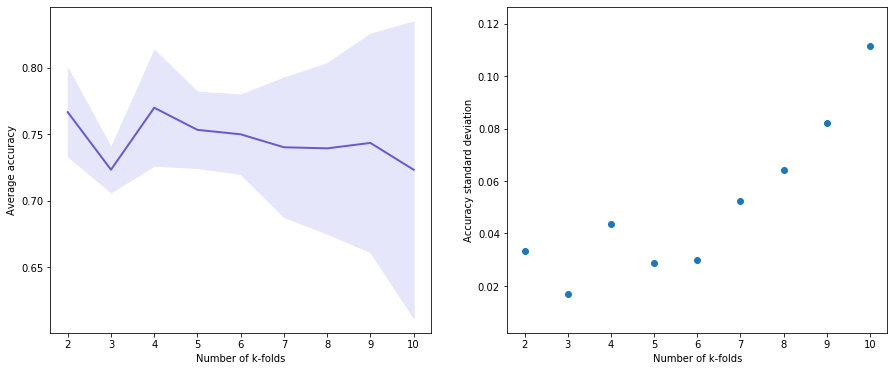


Index of point where accuracy has the smallest standard deviation: 1

Number of k-folds where accuracy has smallest standard deviation: 3.0000
Average accuracy at Number of k-folds with the smallest standard deviation: 0.7233


In [6]:
show_averages_and_variations(kfolds_list, scores_summary["test_accuracy"][0], 
                                          scores_summary["test_accuracy"][1], 
                                          x_name="Number of k-folds", metric_name="accuracy")

### Low k-fold numbers with 10 repetitions
For low k-fold numbers there are less values to average and the signal is more noisy, to solve that, we can set the repetitions option to > 1 to repeat the cross-validation several times for each k-fold and average those values. Here we show the case were 30 repetitions of each k-fold value cross-validation is carried out and all values for each k-fold number are averaged.

In [7]:
kfolds_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
kfolds_list, scores_summary = explore_cross_validation_kfolds(dataset, pipeline, metrics=metrics, 
                                                              kfolds_list=kfolds_list, repetitions=10, 
                                                              minimum_kfolds=False)

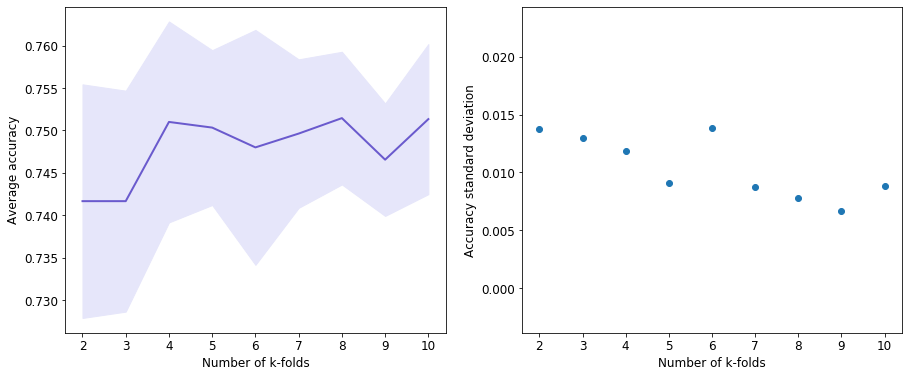


Index of point where accuracy has the smallest standard deviation: 7

Number of k-folds where accuracy has smallest standard deviation: 9.0000
Average accuracy at Number of k-folds with the smallest standard deviation: 0.7466


In [8]:
show_averages_and_variations(kfolds_list, scores_summary["test_accuracy"][0], 
                                          scores_summary["test_accuracy"][1], 
                                          x_name="Number of k-folds", metric_name="accuracy")

### Low k-fold numbers with 50 repetitions
For low k-fold numbers there are less values to average and the signal is more noisy, to solve that, we can set the repetitions option to > 1 to repeat the cross-validation several times for each k-fold and average those values. Here we show the case were 50 repetitions of each k-fold value cross-validation is carried out and all values for each k-fold number are averaged.

In [9]:
kfolds_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
kfolds_list, scores_summary = explore_cross_validation_kfolds(dataset, pipeline, metrics=metrics, 
                                                              kfolds_list=kfolds_list, repetitions=50, 
                                                              minimum_kfolds=False)

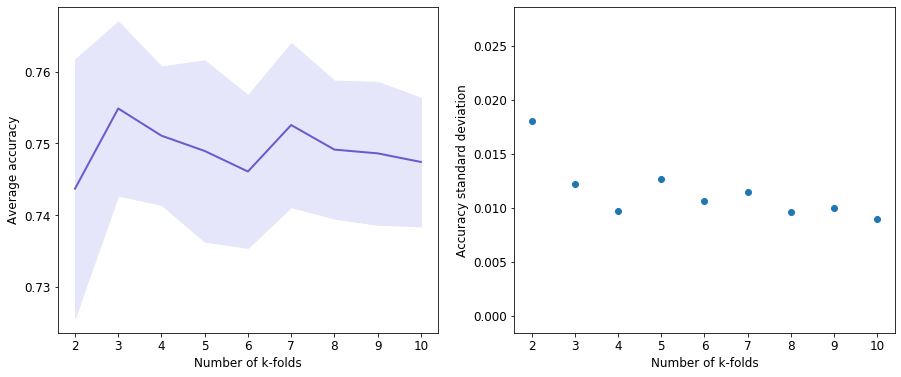


Index of point where accuracy has the smallest standard deviation: 8

Number of k-folds where accuracy has smallest standard deviation: 10.0000
Average accuracy at Number of k-folds with the smallest standard deviation: 0.7474


In [10]:
show_averages_and_variations(kfolds_list, scores_summary["test_accuracy"][0], 
                                          scores_summary["test_accuracy"][1], 
                                          x_name="Number of k-folds", metric_name="accuracy")

### High k-fold numbers and no repetitions
For high k-fold numbers there are many values to average and the signal is normally smooth, so no repetitions are needed.

In [11]:
kfolds_list = [2, 10, 50, 100, 150, 200, 250, 300]
kfolds_list, scores_summary = explore_cross_validation_kfolds(dataset, pipeline, metrics=metrics, 
                                                              kfolds_list=kfolds_list, repetitions=1, 
                                                              minimum_kfolds=False)

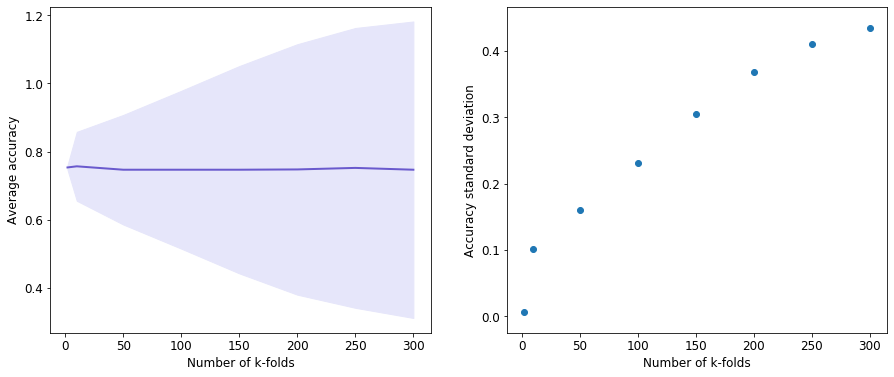


Index of point where accuracy has the smallest standard deviation: 0

Number of k-folds where accuracy has smallest standard deviation: 2.0000
Average accuracy at Number of k-folds with the smallest standard deviation: 0.7533


In [12]:
show_averages_and_variations(kfolds_list, scores_summary["test_accuracy"][0], 
                                          scores_summary["test_accuracy"][1], 
                                          x_name="Number of k-folds", metric_name="accuracy")

### Low and high k-fold numbers with no repetitions
For mixed number of k-folds (low and high values) we might want to set up a repetition number for low k-fold values, to get better statistics, and diregard it for larger k-fold values, to save computational time. For this we can set "minimum_kfolds" to True, which will repeat the cross-validation as necessary for low k-fold values until the "repetitions" goal is reached.

In [13]:
kfolds_list = [2, 3, 4, 5, 10, 25, 40]
kfolds_list, scores_summary = explore_cross_validation_kfolds(dataset, pipeline, metrics=metrics, 
                                                              kfolds_list=kfolds_list, repetitions=1, 
                                                              minimum_kfolds=False)

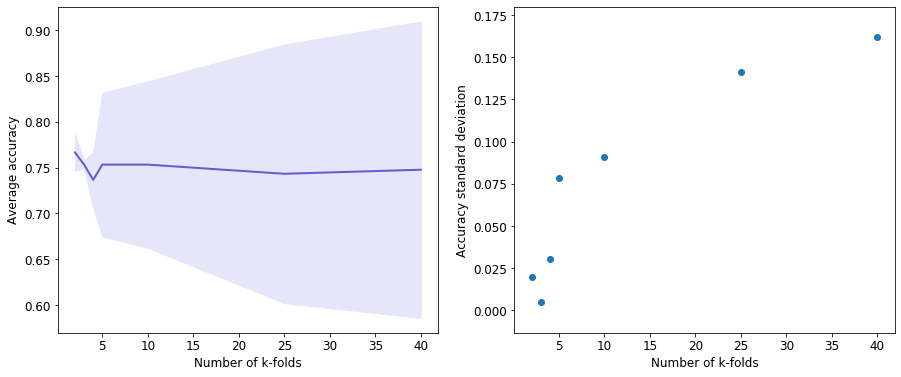


Index of point where accuracy has the smallest standard deviation: 1

Number of k-folds where accuracy has smallest standard deviation: 3.0000
Average accuracy at Number of k-folds with the smallest standard deviation: 0.7533


In [14]:
show_averages_and_variations(kfolds_list, scores_summary["test_accuracy"][0], 
                                          scores_summary["test_accuracy"][1], 
                                          x_name="Number of k-folds", metric_name="accuracy")

### Low and high k-fold numbers with minimum number of repetitions
For mixed number of k-folds we might want to set up a repetition number for low k-fold values and diregard it for larger k-fold values, to save computational time. For this we can set "minimum_kfolds" to True, which will repeat the cross-validation as necessary for low k-fold values until the "repetitions" goal is reached. In this case, with repetitions set to 400, it means that for the largest number of k-folds the cross-validation will be repeated 10 times and for the other values it will be a larger number of repetitions.

In [15]:
kfolds_list = [2, 3, 4, 5, 10, 25, 40]
kfolds_list, scores_summary = explore_cross_validation_kfolds(dataset, pipeline, metrics=metrics, 
                                                              kfolds_list=kfolds_list, repetitions=400, 
                                                              minimum_kfolds=True)

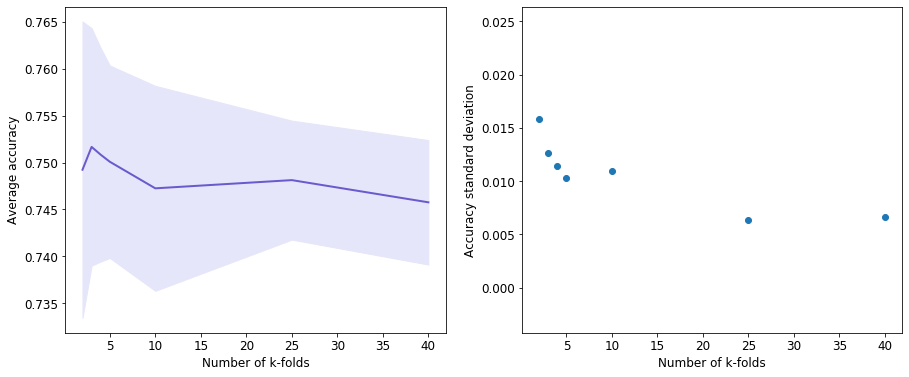


Index of point where accuracy has the smallest standard deviation: 5

Number of k-folds where accuracy has smallest standard deviation: 25.0000
Average accuracy at Number of k-folds with the smallest standard deviation: 0.7481


In [16]:
show_averages_and_variations(kfolds_list, scores_summary["test_accuracy"][0], 
                                          scores_summary["test_accuracy"][1], 
                                          x_name="Number of k-folds", metric_name="accuracy")

### Other metrics
So far only is possible to explore the "accuracy" metric. The fit and score times are also computed but they correspond to a single cross-validation run.

In [17]:
kfolds_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
kfolds_list, scores_summary = explore_cross_validation_kfolds(dataset, pipeline, metrics=metrics, 
                                                              kfolds_list=kfolds_list, repetitions=1, 
                                                              minimum_kfolds=False)

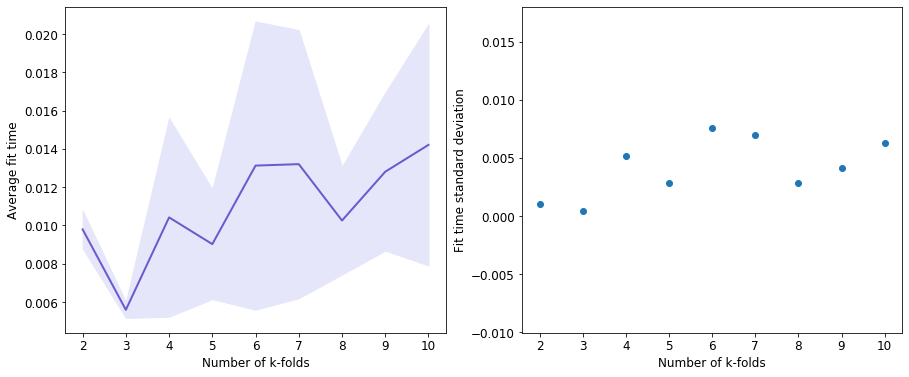


Index of point where fit time has the smallest standard deviation: 1

number of k-folds where fit time has smallest standard deviation: 3.0000
Average fit time at number of k-folds with the smallest standard deviation: 0.0056


In [18]:
show_averages_and_variations(kfolds_list, scores_summary["fit_time"][0], 
                                          scores_summary["fit_time"][1], 
                                          x_name="number of k-folds", metric_name="fit time")

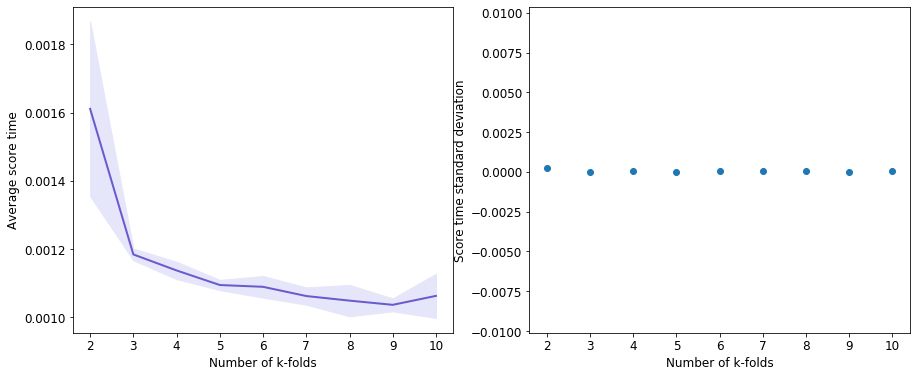


Index of point where score time has the smallest standard deviation: 3

number of k-folds where score time has smallest standard deviation: 5.0000
Average score time at number of k-folds with the smallest standard deviation: 0.0011


In [19]:
show_averages_and_variations(kfolds_list, scores_summary["score_time"][0], 
                                          scores_summary["score_time"][1], 
                                          x_name="number of k-folds", metric_name="score time")